In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.layers import Dense, LSTM

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
# Read data from excel file

df = pd.DataFrame(pd.read_excel('Excel data.xlsx'))

In [3]:
#Examine Data

df.tail()

,Unnamed: 0,name,molweight,critical temperature (K),acentric factor,boiling point (K),Unnamed: 6,Unnamed: 7,Ratio
6026,6136,water,18.01528,647.13,0.3449,373.15,NaN,NaN,NaN
6027,6137,xylenes,106.16740,620.21,0.3170,413.15,NaN,NaN,NaN
6028,6142,zirconium bromide,410.84000,805.00,0.3100,633.15,NaN,NaN,NaN
6029,6143,zirconium chloride,233.03480,778.00,0.2980,604.15,NaN,NaN,NaN
6030,6144,zirconium iodide,598.84188,960.00,0.3430,704.15,NaN,NaN,NaN


In [4]:
#Create second dataframe with first two characteristics to examine

data1 = [df['molweight'], df['boiling point (K)']]
df_1 = pd.DataFrame(data1)
df_1 = df_1.T
df_1.tail()

,molweight,boiling point (K)
6026,18.01528,373.15
6027,106.16740,413.15
6028,410.84000,633.15
6029,233.03480,604.15
6030,598.84188,704.15


Text(0.5, 1.0, 'Boiling point of compounds by molecular weight')

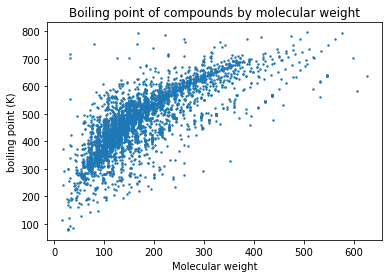

In [5]:
#Plot BP as a function of MW, some degree of correlation although non linear

plt.scatter(df_1['molweight'], df['boiling point (K)'], s=2)
plt.xlabel('Molecular weight')
plt.ylabel('boiling point (K)')
plt.title('Boiling point of compounds by molecular weight')

# ML 1, univariate regression


In [6]:
#Create a training dataset and a testing dataset (n.b. test dataset is technically a validation step, there is no test dataset)

#This is done to show model is effective on data it hasn't seen yet

train_dataset = df_1.sample(frac=0.8,random_state=0) #Randomises 80% of data to be used for training
test_dataset = df_1.drop(train_dataset.index) #The remaining 20% of data is used for testing

train_dataset.tail()

,molweight,boiling point (K)
3436,194.360440,528.15
4256,54.451103,172.05
5838,230.821080,571.15
4899,98.101440,443.15
5404,284.482640,648.35


In [7]:
#Cut the label 'Boiling point' and put it in two smaller datasets for training and testing

train_labels = train_dataset.pop('boiling point (K)') 
test_labels = test_dataset.pop('boiling point (K)')

In [8]:
#This is old data here, kept it in as it still works but is more basic than the following cell

#def build_model():
 #   model = keras.Sequential([
  #      layers.Dense(4, activation='relu', input_shape=[len(train_dataset.keys())]),
   #     layers.Dense(4, activation='relu'),
    #    layers.Dense(1)
    #])
    
    #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.002)

    #model.compile(loss='mse',
     #           optimizer=optimizer,
      #          metrics=['mae', 'mse'])
    #return model

In [9]:
#Constructing the model to be used

def build_model():
    
    #Sequential model used, which is a linear stack of layers
    model = keras.Sequential() 
    
    #First hidden layer here, which has 3 nodes and takes 1 input (the )
    model.add(Dense(3, input_shape=[len(train_dataset.keys())])) 
    
    #Second hidden layer here, which also has 3 nodes. Input shape does not need to be specified. Bias is initialized as 300
    #because this gives a better correlation (done by intuition)
    model.add(Dense(3, bias_initializer=initializers.Constant(300)))

    #Final (output) layer initialized here
    model.add(Dense(1))
    
    #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.002) #This would allow the learning rate to be changed if the 
    #optimizer=optimizer is used when compiling
    
    #Compile the model to minimise the loss function (mean square error). Optimizer is Adam, arguably the best for most functions
    # the learning rate does not need to be changed. Metrics are also reported, however not used to optimise loss
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) 

    return model

In [10]:
model = build_model()

In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 20

#Fits the training dataset (just MW here) to the training labels (BP)

history = model.fit(
  train_dataset, train_labels,
    batch_size=5, #Number of samples per batch. more = quicker
    epochs=EPOCHS, #Number of iterations. More can mean a more accurate model, at the cost of training time
    validation_split = 0.2,
    verbose=0, #Changed to 0 here to prevent data spooling out
  callbacks=[PrintDot()])


....................

In [12]:
#Place iteration data into a dataframe (used to plot graphs)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
15,3791.898266,43.731709,3791.900879,3762.019295,43.701092,3762.019775,15
16,3790.025211,43.670460,3790.024658,3743.015911,43.249084,3743.016357,16
17,3784.523270,43.593872,3784.526123,3824.074924,44.463985,3824.076172,17
18,3797.246847,43.779045,3797.246582,3780.809593,43.885605,3780.809570,18
19,3808.620732,43.850491,3808.620361,3755.351697,43.571835,3755.351562,19


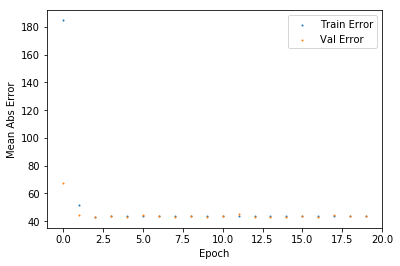

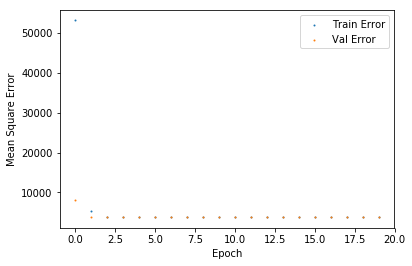

In [15]:
#Plotting to examine error. Note formula needs to change if doing multi or univariate excersise

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.scatter(hist['epoch'], hist['mae'],
           label='Train Error',
               s=1)
    plt.scatter(hist['epoch'], hist['val_mae'],
           label = 'Val Error',
               s=1)
    #plt.ylim([0,0.03]) #Comment this out if running univaiate
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.scatter(hist['epoch'], hist['mse'],
           label='Train Error',
               s=1)
    plt.scatter(hist['epoch'], hist['val_mse'],
           label = 'Val Error',
               s=1)
    #plt.ylim([0,0.2]) #Comment this out if running univaiate
    plt.legend()
    plt.show()


plot_history(history)

In [158]:
#generate predictions, first from the test (validation) sample and then the entire sample

test_predictions = model.predict(test_dataset).flatten()
test_pred_full = model.predict(df['molweight']).flatten()

In [28]:
#Function for plotting graphs 

def do_graphs(test_labels, test_predictions, test_dataset_weight, or_molweight, or_bp, test_predictions_full):

    plt.scatter(test_labels, test_predictions, s=0.5, color='black')
    plt.xlabel('True boiling point (K)')
    plt.ylabel('Predicted boilig point (K)')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 1000], [-100, 1000])
    plt.show()

    plt.scatter(test_dataset_weight, test_predictions)
    plt.show()

    plt.scatter(or_molweight, or_bp, s=2)
    plt.scatter(or_molweight, test_predictions_full, color='black')
    plt.xlabel('Molecular weight')
    plt.ylabel('boiling point (K)')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    plt.title('Boiling point of compounds by molecular weight')
    plt.show()


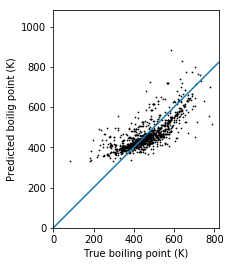

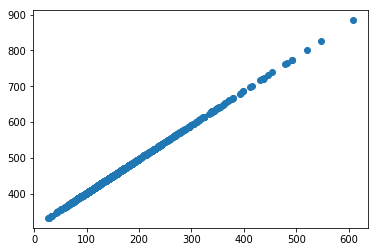

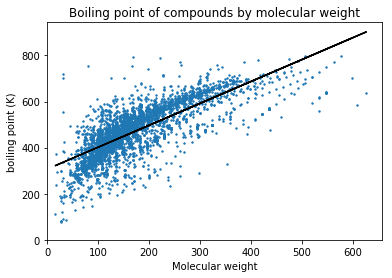

In [166]:
do_graphs(test_labels, test_predictions, test_dataset['molweight'], df['molweight'], df['boiling point (K)'], test_pred_full)

# ML2 Multivariate regression

In [17]:
#Create a new dataframe, that now has MW, acentric factor as the inputs, and T ratio as the output

df_2 = df_1
df_2['T ratio'] = df['boiling point (K)'] / df['critical temperature (K)']
df_2['acc fac'] = df['acentric factor']
df_2 = df_2.drop(['boiling point (K)'], axis=1)

In [18]:
df_full_test = df_2.drop(['T ratio'], axis=1)

In [19]:
#As before, split the new dataframe into training and test (validation) samples, then cut the labels out into seperate list

train_dataset_2 = df_2.sample(frac=0.8,random_state=0)
test_dataset_2 = df_2.drop(train_dataset.index)

train_labels_2 = train_dataset_2.pop('T ratio')
test_labels_2 = test_dataset_2.pop('T ratio')

In [21]:
#Building the new model. Here 7 nodes are used as there are more inputs

def build_model():
    
    model = keras.Sequential()
    model.add(Dense(7, input_shape=[len(train_dataset_2.keys())]))
    model.add(Dense(7)) #No bias this time as expected to go through origin (default = 0)
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.05)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

In [22]:
model = build_model()

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 150 #More epochs required here

history_2 = model.fit(
    train_dataset_2, 
    train_labels_2,
    batch_size=5,
    epochs=EPOCHS, 
    validation_split = 0.2, 
    verbose=1,
    callbacks=[PrintDot()])

Train on 3860 samples, validate on 965 samples
Epoch 1/150
3860/3860 [==============================] - 1s 258us/sample - loss: 36.2899 - mae: 0.3638 - mse: 36.2899 - val_loss: 0.0048 - val_mae: 0.0609 - val_mse: 0.0048
Epoch 2/150
3860/3860 [==============================] - 1s 231us/sample - loss: 0.0039 - mae: 0.0510 - mse: 0.0039 - val_loss: 0.0031 - val_mae: 0.0451 - val_mse: 0.0031
Epoch 3/150
3860/3860 [==============================] - 1s 230us/sample - loss: 0.0030 - mae: 0.0442 - mse: 0.0030 - val_loss: 0.0027 - val_mae: 0.0456 - val_mse: 0.0027
Epoch 4/150
3860/3860 [==============================] - 1s 218us/sample - loss: 0.0023 - mae: 0.0386 - mse: 0.0023 - val_loss: 0.0020 - val_mae: 0.0343 - val_mse: 0.0020
Epoch 5/150
3860/3860 [==============================] - 1s 229us/sample - loss: 0.0018 - mae: 0.0345 - mse: 0.0018 - val_loss: 0.0015 - val_mae: 0.0318 - val_mse: 0.0015
Epoch 6/150
3860/3860 [==============================] - 1s 212us/sample - loss: 0.0015 - mae: 0

3860/3860 [==============================] - 1s 224us/sample - loss: 7.7127e-04 - mae: 0.0200 - mse: 7.7127e-04 - val_loss: 6.9971e-04 - val_mae: 0.0198 - val_mse: 6.9971e-04
Epoch 45/150
3860/3860 [==============================] - 1s 208us/sample - loss: 7.6729e-04 - mae: 0.0200 - mse: 7.6729e-04 - val_loss: 6.9865e-04 - val_mae: 0.0198 - val_mse: 6.9865e-04
Epoch 46/150
3860/3860 [==============================] - 1s 225us/sample - loss: 7.8585e-04 - mae: 0.0202 - mse: 7.8585e-04 - val_loss: 6.9217e-04 - val_mae: 0.0194 - val_mse: 6.9217e-04
Epoch 47/150
3860/3860 [==============================] - 1s 212us/sample - loss: 7.7304e-04 - mae: 0.0200 - mse: 7.7304e-04 - val_loss: 6.8933e-04 - val_mae: 0.0193 - val_mse: 6.8933e-04
Epoch 48/150
3860/3860 [==============================] - 1s 209us/sample - loss: 7.6645e-04 - mae: 0.0199 - mse: 7.6646e-04 - val_loss: 8.3386e-04 - val_mae: 0.0202 - val_mse: 8.3386e-04
Epoch 49/150
3860/3860 [==============================] - 1s 208us/sample

Epoch 88/150
3860/3860 [==============================] - 1s 208us/sample - loss: 7.2850e-04 - mae: 0.0193 - mse: 7.2850e-04 - val_loss: 8.9361e-04 - val_mae: 0.0206 - val_mse: 8.9361e-04
Epoch 89/150
3860/3860 [==============================] - 1s 212us/sample - loss: 7.3744e-04 - mae: 0.0193 - mse: 7.3744e-04 - val_loss: 6.4802e-04 - val_mae: 0.0185 - val_mse: 6.4802e-04
Epoch 90/150
3860/3860 [==============================] - 1s 225us/sample - loss: 7.3552e-04 - mae: 0.0192 - mse: 7.3552e-04 - val_loss: 8.2629e-04 - val_mae: 0.0226 - val_mse: 8.2629e-04
Epoch 91/150
3860/3860 [==============================] - 1s 212us/sample - loss: 7.4763e-04 - mae: 0.0196 - mse: 7.4763e-04 - val_loss: 6.7898e-04 - val_mae: 0.0196 - val_mse: 6.7898e-04
Epoch 92/150
3860/3860 [==============================] - 1s 212us/sample - loss: 7.4962e-04 - mae: 0.0194 - mse: 7.4962e-04 - val_loss: 6.5013e-04 - val_mae: 0.0189 - val_mse: 6.5013e-04
Epoch 93/150
3860/3860 [==============================] - 1s

Epoch 131/150
3860/3860 [==============================] - 1s 208us/sample - loss: 7.1996e-04 - mae: 0.0191 - mse: 7.1996e-04 - val_loss: 7.1301e-04 - val_mae: 0.0187 - val_mse: 7.1301e-04
Epoch 132/150
3860/3860 [==============================] - 1s 211us/sample - loss: 7.5013e-04 - mae: 0.0194 - mse: 7.5013e-04 - val_loss: 6.4103e-04 - val_mae: 0.0185 - val_mse: 6.4103e-04
Epoch 133/150
3860/3860 [==============================] - 1s 208us/sample - loss: 7.3085e-04 - mae: 0.0192 - mse: 7.3085e-04 - val_loss: 6.8133e-04 - val_mae: 0.0184 - val_mse: 6.8133e-04
Epoch 134/150
3860/3860 [==============================] - 1s 211us/sample - loss: 7.4552e-04 - mae: 0.0193 - mse: 7.4552e-04 - val_loss: 7.1182e-04 - val_mae: 0.0187 - val_mse: 7.1182e-04
Epoch 135/150
3860/3860 [==============================] - 1s 225us/sample - loss: 7.4471e-04 - mae: 0.0195 - mse: 7.4471e-04 - val_loss: 8.3918e-04 - val_mae: 0.0229 - val_mse: 8.3918e-04
Epoch 136/150
3860/3860 [==============================

In [23]:
hist_2 = pd.DataFrame(history_2.history)
hist_2['epoch'] = history_2.epoch
hist_2.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
145,0.000759,0.019501,0.000759,0.000665,0.019303,0.000665,145
146,0.000744,0.019437,0.000744,0.001144,0.027548,0.001144,146
147,0.000750,0.019497,0.000750,0.000759,0.019182,0.000759,147
148,0.000733,0.019189,0.000733,0.000651,0.018304,0.000651,148
149,0.000743,0.019400,0.000743,0.000666,0.018310,0.000666,149


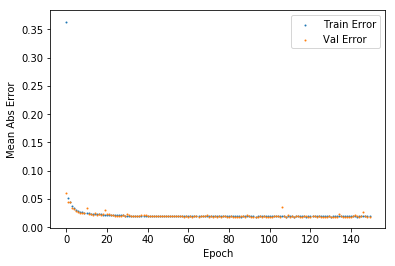

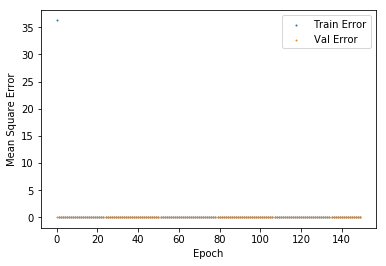

In [24]:
plot_history(history_2)

In [25]:
#Generate preditions as before

test_predictions_2 = model.predict(test_dataset_2).flatten()
test_pred_full_2 = model.predict(df_full_test).flatten()

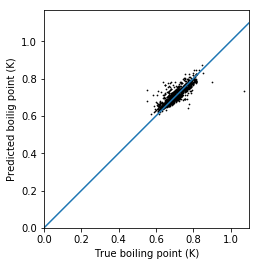

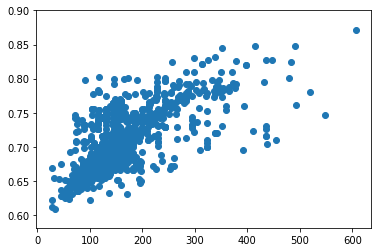

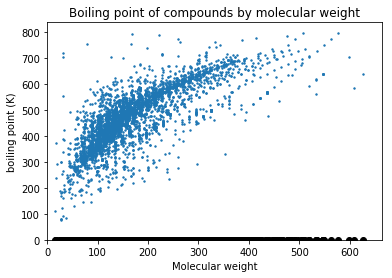

In [30]:
do_graphs(test_labels_2, test_predictions_2, test_dataset_2['molweight'], df['molweight'], df['boiling point (K)'], test_pred_full_2)

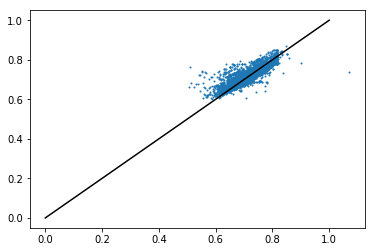

In [32]:
plt.scatter(df_2['T ratio'], test_pred_full_2, s=1)
plt.plot([0,1], [0,1], color='black')
